# Image Segmentation from membrane images
Cell segmentation from images showing membranes can be challenging, e.g. as some markers do not mark membranes continously. Thus, some pre-processing needs to be done in order to retrieve optimal segmentation results.

To demonstrate the workflow, we're using single slices derived from 3D image data from the [Broad Bio Image Challenge](https://bbbc.broadinstitute.org/BBBC034), Thirstrup et al. 2018, available from the Broad Bioimage Benchmark Collection, Ljosa V, Sokolnicki KL, Carpenter AE (2012). Annotated high-throughput microscopy image sets for validation. Nature Methods 9(7):637 / doi. PMID: 22743765 PMCID: PMC3627348. Available at http://dx.doi.org/10.1038/nmeth.2083

We start by opening an example image and configuring an intersting sub-region.

In [1]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import numpy as np

input_image = imread("BBBC034_v1_dataset/AICS_12_134_C=0.tif")

Next, we initialize the GPU

In [2]:
import pyclesperanto_prototype as cle

# select a specific OpenCL / GPU device and see which one was chosen
cle.select_device('RTX')

<Apple M1 Max on Platform: Apple (2 refs)>

Initially, we push the image to GPU memory and segment it using thresholding to see how good it can be done right away.

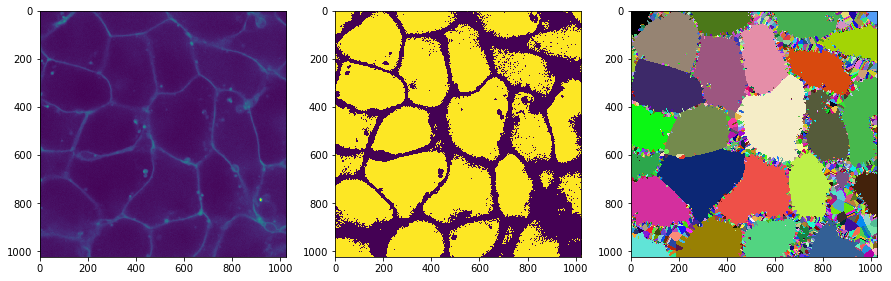

In [3]:
binary = cle.binary_not(cle.threshold_otsu(input_image))

labels = cle.voronoi_labeling(binary)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
cle.imshow(input_image, plot=axs[0])
cle.imshow(binary, plot=axs[1])
cle.imshow(labels, plot=axs[2], labels=True)

Alternatively, with some intermediate correction, e.g. binary opening, we can improve segmentation quality in the binary image before labeling individual objects.

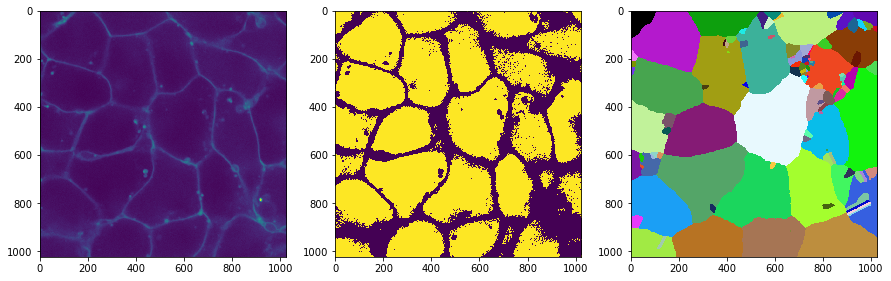

In [4]:
binary = cle.binary_not(cle.threshold_otsu(input_image))

# binary opening, a.k.a. binary erosion followed by binary dilation:
corrected_binary = cle.maximum_box(cle.minimum_box(binary, radius_x=2, radius_y=2), radius_x=2, radius_y=2)

labels = cle.voronoi_labeling(corrected_binary)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
cle.imshow(input_image, plot=axs[0])
cle.imshow(binary, plot=axs[1])
cle.imshow(labels, plot=axs[2], labels=True)

Alternatively, we can improve segmentation quality by making the membranes virtualy thicker in the original image before thresholding:

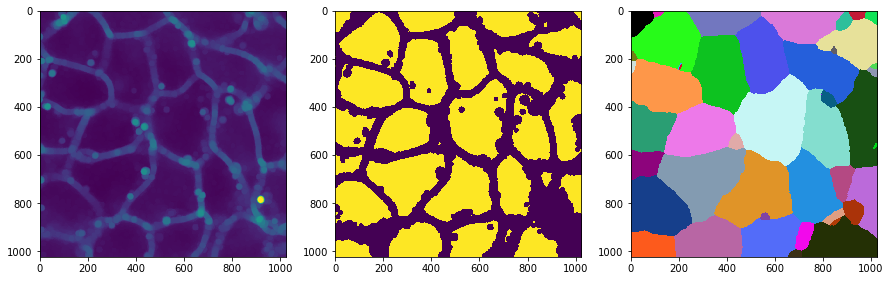

In [5]:
# grey value dilation, a.k.a. a maximum-filter
thicker_membranes = cle.maximum_sphere(input_image, radius_x=10, radius_y=10)

binary = cle.binary_not(cle.threshold_otsu(thicker_membranes))

labels = cle.voronoi_labeling(binary)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
cle.imshow(thicker_membranes, plot=axs[0])
cle.imshow(binary, plot=axs[1])
cle.imshow(labels, plot=axs[2], labels=True)